# Outlook

In this colab we will investigate the **value iteration** and **policy
iteration** algorithms in a maze environment.

# Installation

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/RL/tme

Mounted at /content/drive
/content/drive/MyDrive/RL/tme


In [2]:
# Installs the necessary Python and system libraries
try:
    from easypip import easyimport, easyinstall, is_notebook
except ModuleNotFoundError as e:
    get_ipython().run_line_magic("pip", "install 'easypip>=1.2.0'")
    from easypip import easyimport, easyinstall, is_notebook
# import os
# os.environ["IMAGEIO_FFMPEG_EXE"] = "/usr/bin/ffmpeg"
easyinstall("bbrl>=0.1.14")
easyinstall("swig")
easyinstall("bbrl_gymnasium>=0.1.3")
easyinstall("tensorboard")
easyinstall("moviepy")
easyinstall("box2d-kengz")

from moviepy.editor import ipython_display as video_display

[easypip] Installing bbrl>=0.1.14
[easypip] Installing swig
[easypip] Installing bbrl_gymnasium>=0.1.3
[easypip] Installing box2d-kengz


In [3]:
import os
from typing import Tuple, List

import numpy as np
if is_notebook():
    get_ipython().run_line_magic("matplotlib", "inline")
import matplotlib.pyplot as plt

easyimport("bbrl_gymnasium")
easyimport("moviepy")
from bbrl_gymnasium.envs.maze_mdp import MazeMDPEnv

# For visualization
if not os.path.isdir("./videos"):
    os.mkdir("./videos")

Matplotlib backend: module://matplotlib_inline.backend_inline


# Agents and MDPs

A reinforcement learning agent interacts with an environment represented as a
Markov Decision Process (MDP). It is defined by a tuple $(S, A, P, r, \gamma)$
where $S$ is the state space, $A$ is the action space, $P(state_t, action_t,
state_{t+1})$ is the transition function, $r(state_t, action_t)$ is the reward
function and $\gamma \in [0, 1]$ is the discount factor.

In what follows we import code to create an MDP corresponding to a random maze
(see https://github.com/osigaud/SimpleMazeMDP for documentation).

In [4]:
import gymnasium as gym
import bbrl_gymnasium

env = gym.make("MazeMDP-v0", kwargs={"width": 5, "height": 5, "ratio": 0.2},render_mode="rgb_array")
env.metadata['render_fps'] = 1
env.reset()

# in dynamic programming, there is no agent moving in the environment
env.set_no_agent()
env.init_draw("The maze")

  logger.warn(

  logger.warn(



Output()

# Dynamic programming

The goal of an RL agent is to find the optimal behaviour, defined by a policy
$\pi$ that assigns an action (or distribution over actions) to each state so
as to maximize the agent's total expected reward. In order to estimate how
good a state is, either a state value function $V(x)$ or a state-action value
function $Q(x,u)$ is used.

Dynamic programming algorithms are used for planning, they require a full
knowledge of the MDP from the agent (in contrast to "true" RL where the agent
does not know the transition and reward functions). They find the optimal
policy by computing a value function $V$ or an action-value function $Q$ over
the state space or state-action space of the given MDP. **Value iteration**
and **policy iteration** are two standard dynamic programming algorithms. You
should study both of them using both $V$ and $Q$, as these algorithms contain
the basic building blocks for most RL algorithms.

## Value Iteration ##

### Value Iteration with the V function ###

When using the $V$ function, **value iteration** aims at finding the optimal
values $V^*$ based on the Bellman Optimality Equation: $$V^*(s) = \max_a \big[
r(s,a) + \gamma \sum_{y \in S} P(s,a,y)V^*(y) \big],$$

where:

*   $r(s, a)$ is the reward obtained from taking action $a$ in state $s$,
*   $P(s, a, y)$ is the probability of reaching state $y$ when taking action
    $a$ in state $s$,
*   $\gamma \in [0,1]$ is a discount factor defining the relative importance
    of long term rewards over short term ones (the closer to 0, the more the
    agent focuses on immediate rewards).

In practice, we start with an initial value function $V^0$ (for instance, the
values of all states are 0), and then we iterate for all states $s$

$$V^{i+1}(s) = \max_a \big[ r(s,a) + \gamma \sum_{y \in S} P(s,a,y)V^i(y)
\big],$$

until the values converge, that is $\forall s, V^{i+1}(s) \approx V^i(s)$. It
is shown that at convergence, $\forall s, V^i(s)= V^*(s)$.

To visualize the policy obtained from **value iteration**, we need to first
define the `get_policy_from_V()` function

In [5]:
def get_policy_from_v(mdp: MazeMDPEnv, v: np.ndarray) -> np.ndarray:
    # Outputs a policy given the state values
    policy = np.zeros(mdp.nb_states)  # initial state values are set to 0
    for x in range(mdp.nb_states):  # for each state x
        if x in mdp.terminal_states:
            policy[x] = np.argmax(mdp.r[x, :])
        else:
            # Compute the value of the state x for each action u of the MDP action space
            v_temp = []
            for u in range(mdp.action_space.n):
                # Process sum of the values of the neighbouring states
                summ = 0
                for y in range(mdp.nb_states):
                    summ = summ + mdp.P[x, u, y] * v[y]
                v_temp.append(mdp.r[x, u] + mdp.gamma * summ)
            policy[x] = np.argmax(v_temp)
    return policy

The `value_iteration_v(mdp)` function below provides the code of **value
iteration** using the $V$ function. It is given as an example from which you
can derive other instances of dynamic programming algorithms. Look at it more
closely, this will help for later questions:

* you can ignore the `mdp.new_render()` and `mdp.render(...)` functions which
  are here to provide the visualization of the iterations.
* find in the code the loop over states, the main loop that performs these
  updates until the values don't change significantly anymore, the main update
  equation. Found them? OK, you can continue...

In [6]:
from gymnasium.wrappers.monitoring.video_recorder import VideoRecorder

def value_iteration_v(mdp: MazeMDPEnv, render: bool = True) -> Tuple[np.ndarray, List[float]]:
    # Value Iteration using the state value v
    v = np.zeros(mdp.nb_states)  # initial state values are set to 0
    v_list = []
    stop = False

    video_recorder = VideoRecorder(mdp, "videos/ValueIterationV.mp4", enabled=render)
    mdp.init_draw("Value iteration V", recorder=video_recorder)

    mdp.draw_v(v, recorder=video_recorder)

    while not stop:
        v_old = v.copy()
        mdp.draw_v(v, recorder=video_recorder)
        # print(mdp.nb_states)
        for x in range(mdp.nb_states):  # for each state x
            # Compute the value of the state x for each action u of the MDP action space
            if x in mdp.terminal_states:
                v[x] = np.max(mdp.r[x, :])
            else:
                v_temp = []
                for u in range(mdp.action_space.n):
                    # Process sum of the values of the neighbouring states
                    summ = 0
                    for y in range(mdp.nb_states):
                        summ = summ + mdp.P[x, u, y] * v_old[y]
                    v_temp.append(mdp.r[x, u] + mdp.gamma * summ)

                # Select the highest state value among those computed
                v[x] = np.max(v_temp)

        # Test if convergence has been reached
        if (np.linalg.norm(v - v_old)) < 0.01:
            stop = True
        v_list.append(np.linalg.norm(v))

    policy = get_policy_from_v(mdp, v)
    mdp.draw_v_pi(v, policy, recorder=video_recorder)
    video_recorder.close()
    return v, v_list

Let us run it on the previously defined MDP

In [7]:
v, v_list = value_iteration_v(env, render=True)

  logger.warn(

  logger.warn(

  logger.warn(

  logger.warn(

  logger.warn(

  logger.warn(

  logger.warn(

  logger.warn(



Moviepy - Building video videos/ValueIterationV.mp4.
Moviepy - Writing video videos/ValueIterationV.mp4



Moviepy - Done !
Moviepy - video ready videos/ValueIterationV.mp4


In [8]:
video_display("./videos/ValueIterationV.mp4")

### Value iteration with the $Q$ function ###

The state-action value function $Q^{\pi}(s,a)$ defines the value of being in
state $s$, taking action $a$ then following policy $\pi$. The Bellman
Optimality Equation for $Q^*$ is $$ Q^*(s,a) =  r(s,a) + \gamma \sum_{y}
P(s,a,y) \max_{a'}Q^*(y,a'). $$

**Question:** By taking inspiration from the `value_iteration_v(mdp)` function
above, fill the blank (given with '\#Q[x,u]=...') in the code of
`value_iteration_q(mdp)`.

In [9]:
# ------------------ Value Iteration with the Q function ---------------------#
# Given a MDP, this algorithm computes the optimal action value function Q
# It then derives the optimal policy based on this function

def value_iteration_q(mdp: MazeMDPEnv, render: bool = True) -> Tuple[np.ndarray, List[float]]:
    q = np.zeros((mdp.nb_states, mdp.action_space.n))  # initial action values are set to 0
    q_list = []
    stop = False

    video_recorder = VideoRecorder(mdp, "videos/ValueIterationQ.mp4", enabled=render)
    mdp.init_draw("Value iteration Q", recorder=video_recorder)

    mdp.draw_v(q, recorder=video_recorder)

    while not stop:
        qold = q.copy()

        mdp.draw_v(q, recorder=video_recorder)

        for x in range(mdp.nb_states):
            for u in range(mdp.action_space.n):
                if x in mdp.terminal_states:
                    q[x, u] = mdp.r[x, u]
                else:
                    summ = 0
                    for y in range(mdp.nb_states):
                        summ += mdp.P[x, u, y] * np.max(qold[y, :])

                    # Compléter d'après la formule ci-dessus

                    q[x, u] = mdp.r[x, u] + mdp.gamma*summ
                    # assert False, 'Not implemented yet'


        if (np.linalg.norm(q - qold)) <= 0.01:
            stop = True
        q_list.append(np.linalg.norm(q))

    mdp.draw_v(q, recorder=video_recorder)
    video_recorder.close()

    return q, q_list

Once you are done, run it.

In [10]:
q, q_list = value_iteration_q(env, render=True)

Moviepy - Building video videos/ValueIterationQ.mp4.
Moviepy - Writing video videos/ValueIterationQ.mp4



Moviepy - Done !
Moviepy - video ready videos/ValueIterationQ.mp4


In [11]:
video_display("videos/ValueIterationQ.mp4")

## Policy Iteration ##

The **policy iteration** algorithm is more complicated than **value iteration**.
Given a MDP and a policy $\pi$, **policy iteration** iterates the following
steps:

*   Evaluate policy $\pi$: compute $V$ or $Q$ based on the policy $\pi$;
*   Improve policy $\pi$: compute a better policy based on $V$ or $Q$.

This process is repeated until convergence, i.e. when the policy cannot be
improved anymore.

### Policy iteration with the $V$ function ###

When using $V$, $V^{\pi}(s)$ is the expected return when starting from state
$s$ and following policy $\pi$. It is processed based on the Bellman
Optimality Equation for deterministic policies:

$$V^\pi(s) = r(s, \pi(s)) + \gamma \sum_{y \in S}P(s, \pi(s), y)V^\pi(y),$$

where:

*   $\pi$ is a deterministic policy, meaning that in a state $s$, the agent
    always selects the same action,
*   $V^\pi(y)$ is the value of the state $y$ under policy $\pi$.

Thus, given a policy $\pi$, one must first compute its value function
$V^\pi(s)$ for all states $s$ iterating the Bellman Optimality Equation until
convergence, that is using **value iteration**. Then, one must determine if
policy $\pi$ can be improved based on $V$. For that, in each state $s$, one
can compute the Q-value $Q(s,a)$ of applying action $a$ and then following
policy $\pi$ based on the just computed $V^\pi$, and replace the action
$\pi(s)$ with $\arg\max_a Q(s,a)$.

In order to facilitate the coding of **policy iteration** algorithms, we first
define a set of useful functions.

The `improve_policy_from_v(mdp, v, policy)` function is very similar to the
`get_policy_from_v(v)` function which was given above. The main difference is
that it takes a policy as argument and improves this policy when possible,
thus is is more in the spirit of the `policy improvement` step of **policy
iteration**. But both functions can be used interchangeably.

The functions `evaluate_one_step_v(mdp, v, policy)`, where `mdp` is a given
MDP, `v` is some value function in this MDP and `policy` is some policy and
the function `evaluate_v(mdp, policy)` are also given. These functions are
used to build the value function $V^\pi$ corresponding to policy $\pi$.

In [12]:
def improve_policy_from_v(mdp: MazeMDPEnv, v: np.ndarray, policy: np.ndarray) -> np.ndarray:
    # Improves a policy given the state values
    for x in range(mdp.nb_states):  # for each state x
        # Compute the value of the state x for each action u of the MDP action space
        if x in mdp.terminal_states:
            policy[x] = np.argmax(mdp.r[x, :])
        else:
            v_temp = np.zeros(mdp.action_space.n)
            for u in range(mdp.action_space.n):
                # Process sum of the values of the neighbouring states
                summ = 0
                for y in range(mdp.nb_states):
                    summ = summ + mdp.P[x, u, y] * v[y]
                v_temp[u] = mdp.r[x, u] + mdp.gamma * summ

            for u in range(mdp.action_space.n):
                if v_temp[u] > v_temp[policy[x]]:
                    policy[x] = u
    return policy

In [13]:
def evaluate_one_step_v(mdp: MazeMDPEnv, v: np.ndarray, policy: np.ndarray) -> np.ndarray:
    # Outputs the state value function after one step of policy evaluation
    # Corresponds to one application of the Bellman Operator
    v_new = np.zeros(mdp.nb_states)  # initial state values are set to 0
    for x in range(mdp.nb_states):  # for each state x
        # Compute the value of the state x for each action u of the MDP action space
        if x in mdp.terminal_states:
            v_new[x] = mdp.r[x, policy[x]]
        else:
            # Process sum of the values of the neighbouring states
            summ = 0
            for y in range(mdp.nb_states):
                summ = summ + mdp.P[x, policy[x], y] * v[y]
            v_new[x] = mdp.r[x, policy[x]] + mdp.gamma * summ
    return v_new

In [14]:
def evaluate_v(mdp: MazeMDPEnv, policy: np.ndarray) -> np.ndarray:
    # Outputs the state value function of a policy
    v = np.zeros(mdp.nb_states)  # initial state values are set to 0
    stop = False
    while not stop:
        vold = v.copy()
        v = evaluate_one_step_v(mdp, vold, policy)

        # Test if convergence has been reached
        if (np.linalg.norm(v - vold)) < 0.01:
            stop = True
    return v

To perform **policy iteration** we also need an initial random policy.

In [15]:
from tabularmazemdp import random_policy

**Question:** By using the above functions, fill the code of the
`policy_iteration_v(mdp)` function below.

In [16]:
# ---------------- Policy Iteration with the V function -----------------#
# Given an MDP, this algorithm simultaneously computes
# the optimal state value function V and the optimal policy

def policy_iteration_v(mdp: MazeMDPEnv, render: bool = True) -> Tuple[np.ndarray, List[float]]:
    # policy iteration over the v function
    v = np.zeros(mdp.nb_states)  # initial state values are set to 0
    v_list = []
    policy = random_policy(mdp)

    stop = False

    video_recorder = VideoRecorder(mdp, "videos/PolicyIterationV.mp4", enabled=render)
    mdp.init_draw("Policy Iteration (V)", recorder=video_recorder)

    while not stop:
        vold = v.copy()

        mdp.draw_v(v, title="Policy iteration Q", recorder=video_recorder)

        # Step 1 : Policy Evaluation
        # To be completed...

        v = evaluate_v(mdp, policy)
        # assert False, 'Not implemented yet'



        # Step 2 : Policy Improvement
        # To be completed...

        policy = improve_policy_from_v(mdp, v, policy)
        # assert False, 'Not implemented yet'


        # Check convergence
        if (np.linalg.norm(v - vold)) < 0.01:
            stop = True
        v_list.append(np.linalg.norm(v))

    mdp.draw_v_pi(v, get_policy_from_v(mdp, v), recorder=video_recorder)
    video_recorder.close()

    return v, v_list

And finally run it.

In [17]:
v, v_list = policy_iteration_v(env, render=True)
video_display("videos/PolicyIterationV.mp4")

Moviepy - Building video videos/PolicyIterationV.mp4.
Moviepy - Writing video videos/PolicyIterationV.mp4



Moviepy - Done !
Moviepy - video ready videos/PolicyIterationV.mp4


### Policy iteration with the $Q$ function ###

The **policy iteration** algorithm with the $Q$ function is the same as with
the $V$ function, but the policy improvement step is more straightforward.

When using $Q$, the Bellman Optimality Equation with deterministic policy
$\pi$ for $Q$ becomes: $$Q^{\pi}(s,a) = r(s,a) + \gamma \sum_{y \in
S}P(s,a,y)Q^{\pi}(y,\pi(y)).$$

The policy can then be updated as follows: $$\pi^{(t+1)}(s) =
\arg\max_aQ^{\pi^{(t)}}(s,a).$$

First, we need to determine a policy from the $Q$ function.

**Question:**  fill the `get_policy_from_q(q)` function, where $q$ is the
state-action value function.

In [33]:
def get_policy_from_q(q: np.ndarray) -> np.ndarray:
    # Outputs a policy given the action values

    return np.argmax(q, axis = 1)
    # assert False, 'Not implemented yet'


**Question:** By drawing inspiration on the functions give with the $v$
function, fill the code of the `evaluate_one_step_q(mdp, q, policy)` function
below, where $q$ is some action value function, and the `evaluate_q(mdp,
policy)` function.

In [19]:
def evaluate_one_step_q(mdp: MazeMDPEnv, q: np.ndarray, policy: np.ndarray) -> np.ndarray:
    # Outputs the state value function after one step of policy evaluation
    qnew = np.zeros((mdp.nb_states, mdp.action_space.n))  # initial action values are set to 0
    for x in range(mdp.nb_states):  # for each state x
        # Compute the value of the state x for each action u of the MDP action space
        for u in range(mdp.action_space.n):
            if x in mdp.terminal_states:
                qnew[x, u] = mdp.r[x, u]
            else:
                # Process sum of the values of the neighbouring states
                summ = 0
                for y in range(mdp.nb_states):
                    # To be completed...

                    summ += mdp.P[x, u, y]*q[y, policy[y]]

                qnew[x, u] = mdp.r[x, u] + mdp.gamma*summ
                # assert False, 'Not implemented yet'
    return qnew

In [20]:
def evaluate_q(mdp: MazeMDPEnv, policy: np.ndarray) -> np.ndarray:
    # Outputs the state value function of a policy
    q = np.zeros((mdp.nb_states, mdp.action_space.n))  # initial action values are set to 0
    stop = False
    while not stop:
        qold = q.copy()
        # To be completed...

        q = evaluate_one_step_q(mdp, qold, policy)

        # Test if convergence has been reached
        if (np.linalg.norm(q - qold)) < 0.01:
            stop = True
    return q

**Question:** By using the above functions, fill the code of the
`policy_iteration_q(mdp)` function below.

In [21]:
# ---------------- Policy Iteration with the Q function -----------------#
# Given a MDP, this algorithm simultaneously computes
# the optimal action value function Q and the optimal policy

def policy_iteration_q(mdp: MazeMDPEnv, render: bool = True) -> Tuple[np.ndarray, List[float]]:
    """policy iteration over the q function."""
    q = np.zeros((mdp.nb_states, mdp.action_space.n))  # initial action values are set to 0
    q_list = []
    policy = random_policy(mdp)

    stop = False

    video_recorder = VideoRecorder(mdp, "videos/PolicyIterationQ.mp4", enabled=render)
    mdp.init_draw("Policy iteration Q", recorder=video_recorder)
    # print(policy)
    while not stop:
        qold = q.copy()

        mdp.draw_v(q, recorder=video_recorder)

        # Step 1 : Policy evaluation
        # To be completed...

        q = evaluate_q(mdp, policy)


        # Step 2 : Policy improvement
        # To be completed...

        policy = get_policy_from_q(q)


        # Check convergence
        if (np.linalg.norm(q - qold)) <= 0.01:
            stop = True
        q_list.append(np.linalg.norm(q))

    mdp.draw_v_pi(q, get_policy_from_q(q), recorder=video_recorder)
    video_recorder.close()
    return q, q_list

Finally, run it.

In [22]:
q, q_list = policy_iteration_q(env, render=True)
video_display("videos/PolicyIterationQ.mp4")

Moviepy - Building video videos/PolicyIterationQ.mp4.
Moviepy - Writing video videos/PolicyIterationQ.mp4



Moviepy - Done !
Moviepy - video ready videos/PolicyIterationQ.mp4


### Study part: Experimental comparisons

We will now compare the efficiency of the various dynamic programming methods
using either the $V$ or the  $Q$ functions.

In all your dymanic programming functions, add code to count the number of
iterations and the number of elementary $V$ or $Q$ updates. Use the provided
`mazemdp.Chrono` class to measure the time taken. You may generate various
mazes of various sizes to figure out the influence of the maze topology.

Build a table where you compare the various dymanic programming functions in
terms of iterations, elementary operations and time taken.

You can run the `plot_convergence_vi_pi(...)` function provided below to
visualize the convergence of the various algorithms.

In [23]:
# ---- plot learning curves of Q-Learning and Sarsa using epsilon-greedy and softmax -----#

def plot_convergence_vi_pi(m, render):
    v, v_list1 = value_iteration_v(m, render)
    q, q_list1 = value_iteration_q(m, render)
    v, v_list2 = policy_iteration_v(m, render)
    q, q_list2 = policy_iteration_q(m, render)

    plt.plot(range(len(v_list1)), v_list1, label='value_iteration_v')
    plt.plot(range(len(q_list1)), q_list1, label='value_iteration_q')
    plt.plot(range(len(v_list2)), v_list2, label='policy_iteration_v')
    plt.plot(range(len(q_list2)), q_list2, label='policy_iteration_q')

    plt.xlabel('Number of episodes')
    plt.ylabel('Norm of V or Q value')
    plt.legend(loc='upper right')
    # plt.savefig("comparison_DP.png")
    plt.title("Comparison of convergence rates")
    plt.show()

**Question:** Run the code below and visualize the results of the different algorithms

  logger.warn("Unable to save last video! Did you call close()?")



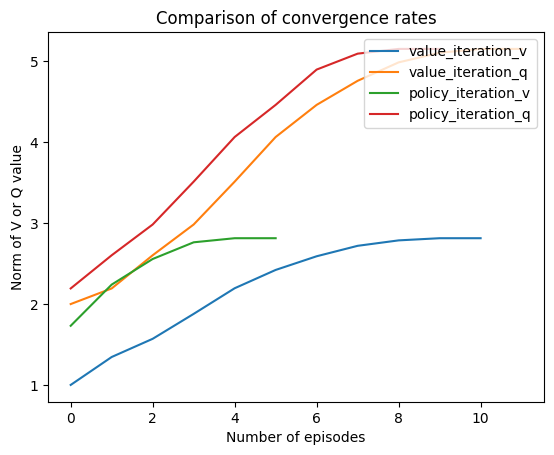

In [24]:
plot_convergence_vi_pi(env, False)

Given the results above, discuss the relative computational
efficiency of these methods.

### Study part: Generalized Policy Iteration

Code the **generalized policy iteration** algorithm and study the influence of
the number of evaluation steps between each improvement step

# Generalized Policy Iteration

## Generalized Policy Iteration with the Q function

In [57]:
def evaluate_one_step_q_count(mdp: MazeMDPEnv, q: np.ndarray, policy: np.ndarray) -> np.ndarray:
    # Outputs the state value function after one step of policy evaluation
    # To be completed...
    return evaluate_one_step_q(mdp, q, policy)


A difference with respect to the previous version is that now we pass the number of iterations K

In [58]:
def evaluate_q_K_steps(mdp: MazeMDPEnv, policy: np.ndarray, q: np.array, K: int) -> np.ndarray:
    # Outputs the state value function of a policy
    # To be completed...

    stop = False
    for i in range(K):
        qold = q.copy()
        # To be completed...

        q = evaluate_one_step_q(mdp, qold, policy)

        # Test if convergence has been reached
        if (np.linalg.norm(q - qold)) < 0.01:
            stop = True
    return q


In [61]:
def generalized_policy_iteration_q(mdp: MazeMDPEnv, render: bool = True, K: int = 1) -> Tuple[np.ndarray, List[float]]:
    """policy iteration over the q function."""
    # To be completed...
    q = np.zeros((mdp.nb_states, mdp.action_space.n))  # initial action values are set to 0
    q_list = []
    policy = random_policy(mdp)

    stop = False

    video_recorder = VideoRecorder(mdp, "videos/GeneralizedPolicyIterationQ.mp4", enabled=render)
    mdp.init_draw("Policy iteration Q", recorder=video_recorder)
    # print(policy)
    i = 0
    while not stop:
        i+=1
        qold = q.copy()
        poold = policy.copy()

        mdp.draw_v(q, recorder=video_recorder)

        # Step 1 : Policy evaluation
        # To be completed...

        q = evaluate_q_K_steps(mdp, poold, qold, K)


        # Step 2 : Policy improvement
        # To be completed...

        policy = get_policy_from_q(q)


        # Check convergence
        if (np.linalg.norm(q - qold)) <= 0.01:
            stop = True
        q_list.append(np.linalg.norm(q))

    mdp.draw_v_pi(q, get_policy_from_q(q), recorder=video_recorder)
    video_recorder.close()
    return q, q_list




In [62]:
q, q_list = generalized_policy_iteration_q(env, render=True, K=1)
video_display("videos/GeneralizedPolicyIterationQ.mp4")

Moviepy - Building video videos/GeneralizedPolicyIterationQ.mp4.
Moviepy - Writing video videos/GeneralizedPolicyIterationQ.mp4



Moviepy - Done !
Moviepy - video ready videos/GeneralizedPolicyIterationQ.mp4


## Generalized Policy Iteration with the V function

In [88]:
def evaluate_one_step_v(mdp: MazeMDPEnv, v: np.ndarray, policy: np.ndarray) -> np.ndarray:
    # Outputs the state value function after one step of policy evaluation
    # Corresponds to one application of the Bellman Operator
    # To be completed...
    v_new = np.zeros(mdp.nb_states)  # initial state values are set to 0
    for x in range(mdp.nb_states):  # for each state x
        if x in mdp.terminal_states: # etats finaux = reward
            v_new[x] = mdp.r[x, policy[x]]
        else:
            somme = 0
            for y in range(mdp.nb_states):
                somme = somme+mdp.P[x, policy[x], y]*v[y]
            v_new[x] = mdp.r[x, policy[x]]+mdp.gamma*somme
    return v_new


A difference with respect to the previous version is that now we pass the number of iterations K

In [103]:
def evaluate_v_count(mdp: MazeMDPEnv, policy: np.ndarray, v: np.array, norms: np.array, K: int, threshold: float) -> np.ndarray:
    # Outputs the state value function of a policy
    # To be completed...
    stop = False
    for i in range(K):
        vold = v.copy()

        v = evaluate_one_step_v(mdp, v, policy)

        # Convergence test
        if (np.linalg.norm(v - vold)) < threshold:
            stop = True
    norms.append(np.linalg.norm(v))
    return v, norms


In [105]:
def generalized_policy_iteration_v(mdp: MazeMDPEnv, K: int = 1, threshold: float = 0.01, render: bool = True) -> Tuple[np.ndarray, List[float]]:
    """policy iteration over the v function."""
    # To be completed...
    v = np.zeros(mdp.nb_states)  # initial state values are set to 0
    v_list = []
    policy = random_policy(mdp)

    stop = False

    video_recorder = VideoRecorder(mdp, "videos/GeneralizedPolicyIterationV.mp4", enabled=render)
    mdp.init_draw("Generalized Policy Iteration (V)", recorder=video_recorder)

    while not stop:
        vold = v.copy()
        mdp.draw_v(v, title="Generalized Policy iteration V", recorder=video_recorder)

        # Step 1 : Policy Evaluation

        v, v_list = evaluate_v_count(mdp, policy, vold, v_list, K, threshold)

        # Step 2 : Policy Improvement

        policy = improve_policy_from_v(mdp, v, policy)

        # Check convergence
        if (np.linalg.norm(v - vold)) <threshold:
            stop = True
        # v_list.append(np.linalg.norm(v))

    mdp.draw_v_pi(v, get_policy_from_v(mdp, v), recorder=video_recorder)
    video_recorder.close()

    return v, v_list


In [106]:
v, v_list = generalized_policy_iteration_v(env, K=1, threshold=0.01, render=True)
video_display("videos/GeneralizedPolicyIterationV.mp4")

Moviepy - Building video videos/GeneralizedPolicyIterationV.mp4.
Moviepy - Writing video videos/GeneralizedPolicyIterationV.mp4



Moviepy - Done !
Moviepy - video ready videos/GeneralizedPolicyIterationV.mp4


Visualization of the results

  logger.warn("Unable to save last video! Did you call close()?")



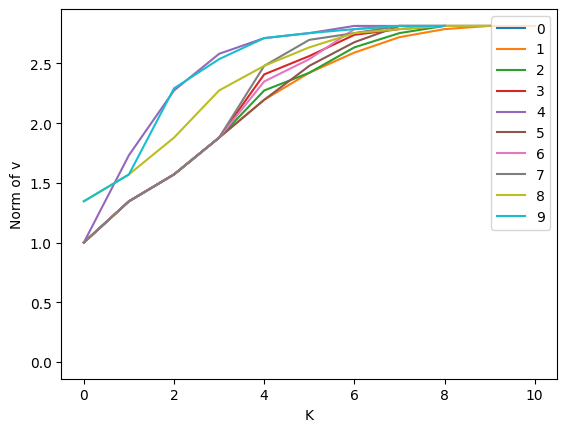

In [107]:
max = 10
threshold=0.00001
for k in range(max):
  # norms = np.zeros(max)
  v, norm = generalized_policy_iteration_v(env, k, threshold, render=False)
  # print(k, ":", norm)
  plt.plot(range(len(norm)), norm, label=k)
  plt.legend(loc='upper right')
  plt.xlabel('K')
  plt.ylabel('Norm of v')
plt.show()